### Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

# custom packages
from ratsimulator import trajectory_generator
from ratsimulator.Environment import Rectangle

import datetime
import sys
import os
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None 

from PlaceCells import PlaceCells
from Models import SorscherRNN
from methods import *
from datahandling import *
import spatial_maps as sm # CINPLA spatial maps

### Set parameters

In [3]:
"""
# Sorscher params
options.save_dir = '/mnt/fs2/bsorsch/grid_cells/models/'
options.n_steps = 100000      # number of training steps
options.batch_size = 200      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096             # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'RNN'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment
"""
_ = 2 # prevent jupyter from printing docstring (messy)

In [4]:
params = {}
# Environment params
params['boxsize'] = (2.2, 2.2)
params['origo'] = (0,0)
params['soft_boundary'] = 0.03 # Sorscher uses 0.03, I used to have 0.2
# Remapping / meta-learning (multiple environments/contexts)
params['num_environments'] = 1
params['sampler'] = 'MESampler'
# Place Cells params
params['npcs'] = 512 # as used in Sorscher model
params['pc_width'] = 0.12
params['DoG'] = True
params['pcc_seeds'] = list(range(1, 1 + params['num_environments'])) # place-cell center seeds
# Training data (Agent) params
params['batch_size'] = 200
params['seq_len'] = 20
params['angle0'] = None # random
params['p0'] = None     # random
# Agent/random walk parameters
params['dt'] = 0.02
params['turn_angle'] = 5.76 * 2
params['b'] = 0.13 * 2 * np.pi
params['mu'] = 0
params['boundary_mode'] = 'sorschers' # 'sorschers' or 'zenos'
# Model params
params['Ng'] = 4096
params['Np'] = params['npcs'] # defined for Brain already
params['weight_decay'] = 1e-5 # Sorscher uses 1e-4 in his publised code - but says he uses 1e-5 in the paper (only for LSTM model?)
params['lr'] = 1e-4# 1e-3 is default for Adam()
params['nsteps'] = 100 # number of mini batches in an epoch
params['nepochs'] = 1000 # number of epochs
# metadata
params['tag'] = 'default_xavier2'
params['date'] = datetime.datetime.now()

num_workers = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

device=device(type='cuda')


### Initialise objects

In [5]:
# Initialise environments
environments = [Rectangle(boxsize=params['boxsize'], soft_boundary=params['soft_boundary'])] * params['num_environments']
params['environment_names'] = [type(environment).__name__ for environment in environments]

# Initialise agents
agents = [Agent(environment = environment, **params) for environment in environments]

# Initialise brain representations
place_cell_ensembles = [PlaceCells(environment = environment, seed = seed, **params) for environment, seed in zip(environments, params['pcc_seeds'])]

# Initialise data loading
num_samples = params['nsteps'] * params['batch_size'] # * params['nepochs']
dataset = Dataset(agents = agents, place_cell_ensembles = place_cell_ensembles, num_samples = num_samples, **params)
datasampler = eval(params['sampler'])(num_environments = len(environments), num_samples = num_samples)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)

# Initialise model
model = SorscherRNN(place_cell_ensembles, Ng=params['Ng'], Np=params['Np']) 
model.to(device)
print(f"{model = }")

# Initialise optimizer (use custom weight decay, rather than torch optim decay)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], betas=(0.9, 0.999), \
                             eps=1e-08, weight_decay=0.0, amsgrad=False)

Singular matrix
Singular matrix
model = SorscherRNN(
  (init_position_encoder): Linear(in_features=512, out_features=4096, bias=False)
  (RNN): RNN(2, 4096, bias=False, batch_first=True)
  (decoder): Linear(in_features=4096, out_features=512, bias=False)
)


### Data pathing. To save/load model weights and results

In [6]:
# create model model tag
model_tag = type(model).__name__ + "_" + params["tag"]
print(f"{model_tag = }")

# create relevant paths
from pathlib import Path
data_path = Path().home() / "data"
project_path = data_path / "emergent-grid-cells"
model_path = project_path / model_tag
checkpoint_path = model_path / "checkpoints"
pickle_path = model_path / "pickle_objects"
print(f"{checkpoint_path = }")
print(f"{pickle_path = }")

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
    os.makedirs(pickle_path)

model_tag = 'SorscherRNN_default_xavier2'
checkpoint_path = PosixPath('/home/users/vemundss/data/emergent-grid-cells/SorscherRNN_default_xavier2/checkpoints')
pickle_path = PosixPath('/home/users/vemundss/data/emergent-grid-cells/SorscherRNN_default_xavier2/pickle_objects')


### Train/Load Model

In [9]:
loss_history = []
training_metrics = {}

model_checkpoints = [f for f in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path, f))]
if model_checkpoints:
    # get latest (wrt. #epochs trained) model weights
    model_checkpoints.sort()
    checkpoint_epoch = model_checkpoints[-1]
    # overwrite and choose manually which weights to load
    #checkpoint_epoch = "0001"
    
    # load model
    print(f"Loading model at epoch = {checkpoint_epoch}")
    checkpoint = torch.load(checkpoint_path / checkpoint_epoch)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss_history = checkpoint['loss_history']
    training_metrics = checkpoint['training_metrics']
    print("Loaded weights")
    
# whether to train
if train:=True:
    loss_history = model.train(trainloader = dataloader, optimizer = optimizer, weight_decay=params['weight_decay'], \
                               nepochs=params['nepochs'], checkpoint_path = checkpoint_path, params = params, \
                               loss_history = loss_history, training_metrics = training_metrics)

Loading model at epoch = 1000
Loaded weights


Epoch=1000/1000, loss=6.149001607894897, decoding_error(pred/true)=0.04117761686444282/0.04008292805403471: 100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


## **Analyse Model**
### Training history

In [10]:
# metrics was saved on gpu... this moves it to cpu again
# checkpoint['training_metrics']['pred_error'] = [checkpoint['training_metrics']['pred_error'][i].detach().cpu().numpy() for i in range(len(checkpoint['training_metrics']['pred_error']))]
# checkpoint['training_metrics']['true_error'] = [checkpoint['training_metrics']['true_error'][i].detach().cpu().numpy() for i in range(len(checkpoint['training_metrics']['true_error']))]

Maximum Entropy possible: 6.2383246250395095


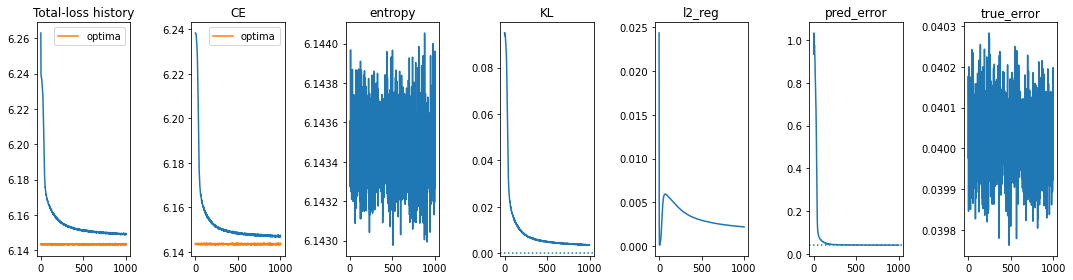

In [11]:
fig, ax = plt.subplots(ncols=len(checkpoint['training_metrics']) + 1,figsize=(15,4))
ax[0].plot(loss_history)
ax[0].plot(checkpoint['training_metrics']['entropy'], label='optima')
ax[0].set_title('Total-loss history')
ax[0].legend()

for i,(key,value) in enumerate(checkpoint['training_metrics'].items()):
    ax[i+1].plot(value)
    ax[i+1].set_title(key)
    if key == 'KL':
        ax[i+1].axhline(0,ls=":")
    if key == 'pred_error':
        ax[i+1].axhline(np.mean(checkpoint['training_metrics']['true_error']),ls=":")
    if key == 'CE':
        ax[i+1].plot(checkpoint['training_metrics']['entropy'], label='optima')
        ax[i+1].legend()

plt.tight_layout()

# maximum labelled distribution entropy (uniform labelled distribution)
n = 512
px = np.ones(n) / n # uniform
entropy = lambda x: -np.sum(x * np.log(x))
print(f"Maximum Entropy possible: {entropy(px)}")

### Create/Load ratemaps

In [12]:
ratemaps_path = pickle_path / "ratemaps"
if not os.path.exists(ratemaps_path):
    os.makedirs(ratemaps_path)

latest_ratemaps_path = ratemaps_path / (model_checkpoints[-1] + ".pkl")
if os.path.exists(latest_ratemaps_path):
    # load ratemaps generated by model that has trained the LONGEST
    with open(latest_ratemaps_path, "rb") as f:
        ratemaps = pickle.load(f)
    print("Loaded ratemaps")
else:
    # generate trajectories to compute ratemaps for
    num_trajectories = 1500
    environment_idx = 0
    batch_velocities, batch_init_pc_positions, batch_positions = [], [], []
    for _ in range(num_trajectories):
        (velocities, init_pc_positions), _, positions, _ = dataset[environment_idx]
        batch_velocities.append(velocities)
        batch_init_pc_positions.append(init_pc_positions)
        batch_positions.append(positions)
    batch_inputs = [torch.stack(batch_velocities), torch.stack(batch_init_pc_positions)]
    batch_positions = torch.stack(batch_positions).detach().numpy()
    x = np.ravel(batch_positions[:,1:,0])
    y = np.ravel(batch_positions[:,1:,1])
    
    # choose neurons to include, and resolution
    idxs = slice(0, params['Ng'], 1)
    res = np.array([32, 32])
    print("Calculating ratemaps")
    # loop all saved model weights - and create ratemaps
    for checkpoint_epoch in tqdm.tqdm(model_checkpoints):
        epoch_ratemaps_path = ratemaps_path / (checkpoint_epoch + ".pkl")
        if os.path.exists(epoch_ratemaps_path):
            # ratemaps for this model checkpoint already calculated and saved
            continue
        
        # load model weights, forward (to g) and compute ratemaps
        checkpoint = torch.load(checkpoint_path / checkpoint_epoch)
        model.load_state_dict(checkpoint['model_state_dict'])
        activities = model.g(batch_inputs).detach().cpu().numpy()
        activities = activities.reshape(-1, activities.shape[-1]).T
        ratemaps = scipy.stats.binned_statistic_2d(x, y, activities, bins=res)[0]
        
        with open(epoch_ratemaps_path, "wb") as f:
            pickle.dump(ratemaps,f)

Calculating ratemaps


100%|██████████| 64/64 [02:02<00:00,  1.91s/it]


### Example ratemaps (unsorted)

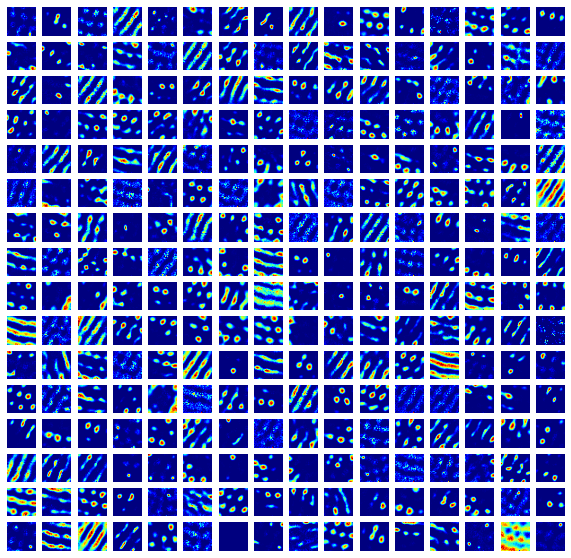

In [13]:
start_idx = 256*1
num_ratemaps = 256
fig, ax = multiimshow(ratemaps[start_idx:start_idx+num_ratemaps])

### Grid score ratemaps (only last model checkpoint)

In [14]:
def score_ratemaps(ratemaps):
    # if grid scores have already been calculate and saved to disk, load these (FAST!)
    score_map_path = pickle_path / (model_checkpoints[-1] + "_grid_scores.pkl")
    if os.path.exists(score_map_path):
        print(os.path.split(score_map_path)[-1], "already exists. Loading score map.")
        with open(score_map_path, "rb") as f:
            score_map = pickle.load(f)
        return score_map
    
    # BANINO (and Sorscher) grid scoring method
    from scores import GridScorer
    res = np.array([32,32])
    starts = [0.2] * 10
    ends = np.linspace(0.4, 1.0, num=10)
    box_width, box_height = params['boxsize']
    coord_range=((params['origo'][0], box_width), (params['origo'][0], box_height))
    coords_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
    mask_parameters = zip(starts, ends.tolist())
    scorer = GridScorer(nbins=res[0], coords_range=coords_range, mask_parameters=mask_parameters)

    # score ratemaps (Could use NUMBA for faster computations?)
    score_map = np.zeros(params['Ng']) # ratemap score lookup table
    print("Calculating grid score for the ratemaps")
    for i in tqdm.trange(params['Ng']):
        # interpolated_ratemap = interpolate_missing_pixels(ratemaps[i], np.isnan(ratemaps[i]))
        # score_map[i] = sm.gridness(interpolated_ratemap)
        score_60, score_90, max_60_mask, max_90_mask, sac = scorer.get_scores(ratemaps[i])
        score_map[i] = score_60

    with open(score_map_path, "wb") as f:
        pickle.dump(score_map,f)
    return score_map

score_map = score_ratemaps(ratemaps)

# sort scores and ratemaps
sort_idxs = np.argsort(score_map)
sorted_scores = score_map[sort_idxs][::-1]
sorted_ratemaps = ratemaps[sort_idxs][::-1]

Calculating grid score for the ratemaps


  0%|          | 0/4096 [00:00<?, ?it/s]/home/users/vemundss/Prosjekter/emergent-grid-cells/notebooks/../src/scores.py:141: RuntimeWarning: invalid value encountered in true_divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))
100%|██████████| 4096/4096 [02:34<00:00, 26.47it/s]


### Example ratemaps (sorted)

Text(0.5, 0.98, 'gc_score = 0.8080467169452704 -- 0.6389193955124944')

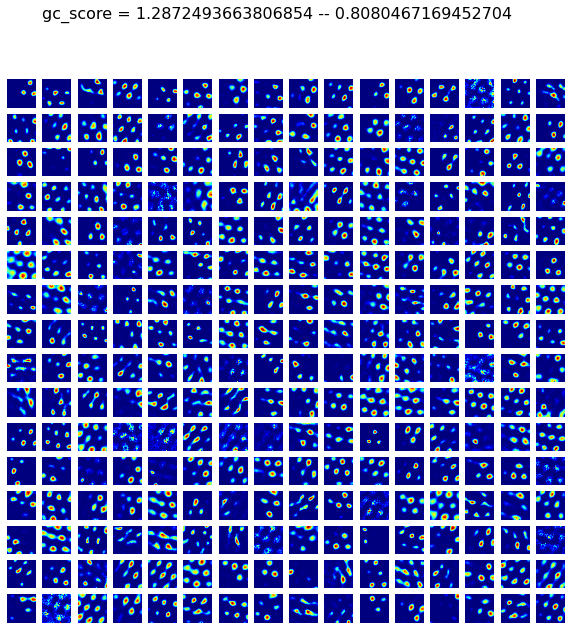

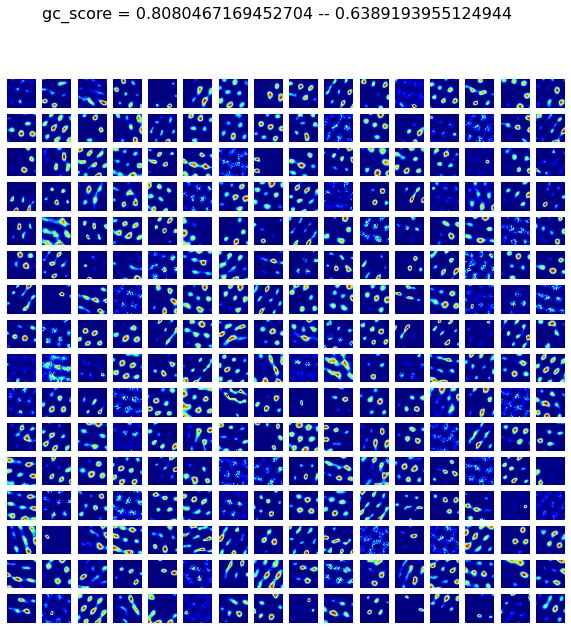

In [15]:
start_idx = 0
num_ratemaps = 256
fig, ax = multiimshow(sorted_ratemaps[start_idx:start_idx+num_ratemaps])
fig.suptitle(f"gc_score = {sorted_scores[start_idx]} -- {sorted_scores[start_idx+num_ratemaps]}", fontsize=16)
fig, ax = multiimshow(sorted_ratemaps[start_idx+num_ratemaps:start_idx+2*num_ratemaps])
fig.suptitle(f"gc_score = {sorted_scores[start_idx+num_ratemaps]} -- {sorted_scores[start_idx+2*num_ratemaps]}", fontsize=16)

### Create grid cell ratemap dynamics (grid cell emergence video)

In [20]:
dynamics_path = model_path / "dynamics"
if not os.path.exists(dynamics_path):
    # create videos
    os.makedirs(dynamics_path)
    ratemap_dynamics = []
    print("Loading ratemaps")
    for checkpoint_epoch in tqdm.tqdm(model_checkpoints):
        with open(ratemaps_path / (checkpoint_epoch + ".pkl"), "rb") as f:
            # load and sort ratemaps wrt. grid score
            ratemap_dynamics.append(pickle.load(f)[sort_idxs][::-1])
    ratemap_dynamics = np.stack(ratemap_dynamics, axis=0)

    from dynamics import RatemapDynamics
    num_gc_in_video = 64
    num_videos = params['Ng'] // num_gc_in_video
    print("Creating videos")
    for gcs_i in tqdm.trange(0, num_videos):
        idxs = slice(gcs_i * num_gc_in_video, (gcs_i + 1) * num_gc_in_video)
        ratemap_video = RatemapDynamics(ratemap_dynamics[:,idxs], sorted_scores[[idxs.start, idxs.stop - 1]])
        ratemap_video.animation.save(dynamics_path / f'{idxs.start}-{idxs.stop - 1}.mp4')

### Predicted place Cells (with(out) SOFTMAX)

In [21]:
"""
forward_with_softmax = lambda x: torch.exp(model(x, log_softmax=True))
ratemaps = compute_ratemaps(model=model, dataset=dataset, num_trajectories=1250, res=res, idxs=idxs)[0]
fig, ax = multiimshow(ratemaps)
"""

'\nforward_with_softmax = lambda x: torch.exp(model(x, log_softmax=True))\nratemaps = compute_ratemaps(model=model, dataset=dataset, num_trajectories=1250, res=res, idxs=idxs)[0]\nfig, ax = multiimshow(ratemaps)\n'

In [22]:
model.prune_mask = list(range(int(4096/2),4096)) # set prune mask
model.prune_mask = [] # reset prune mask
model.prune_mask

[tensor([[1., 1.],
         [1., 1.],
         [1., 1.],
         ...,
         [1., 1.],
         [1., 1.],
         [1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')]

/home/users/vemundss/anaconda3/envs/ml/lib/python3.9/site-packages/torch/nn/modules/rnn.py:268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1635068699003/work/aten/src/ATen/native/cudnn/RNN.cpp:925.)
  result = _impl(input, hx, self._flat_weights, self.bias, self.num_layers,


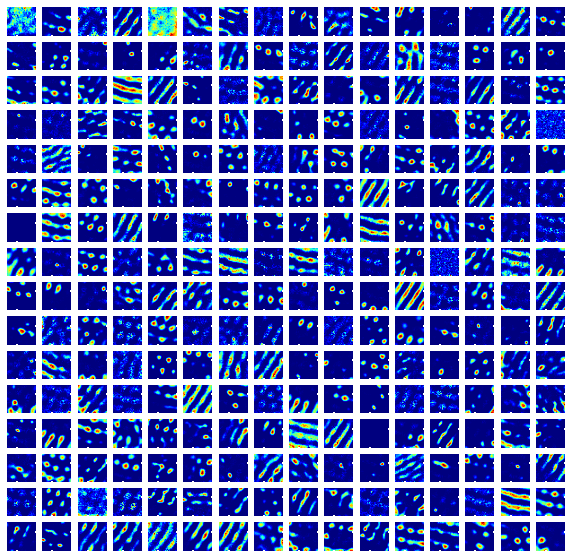

In [23]:
idxs=slice(0, 16**2, 1)
res=np.array([32, 32])
ratemaps = compute_ratemaps(model=model.g, dataset=dataset, num_trajectories=1250, res=res, idxs=idxs)[0]
fig, ax = multiimshow(ratemaps)

### Decoding labels and predictions to cartesian

In [24]:
environment_idx = 0
[[vel, init_pos], labels, positions, index] = dataset[environment_idx]
true_cartesian_pos = positions
true_decoded_pos = place_cell_ensembles[environment_idx].to_euclid(torch.cat([init_pos[None], labels]))
pc_preds = model([vel, init_pos]).detach().cpu()[0]
predicted_decoded_pos = place_cell_ensembles[environment_idx].to_euclid(torch.cat([init_pos[None], pc_preds]))

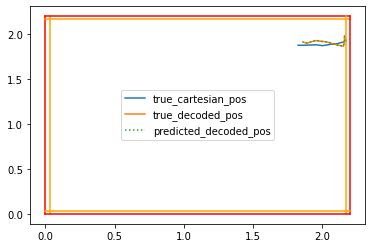

In [25]:
fig, ax = plt.subplots()
ax.plot(*true_cartesian_pos.T, label='true_cartesian_pos')
ax.plot(*true_decoded_pos.T, label='true_decoded_pos')
ax.plot(*predicted_decoded_pos.T, label='predicted_decoded_pos', ls=':')
environments[environment_idx].plot_board(ax)
ax.legend()

### Plot all place cell centers and some with tuning curves

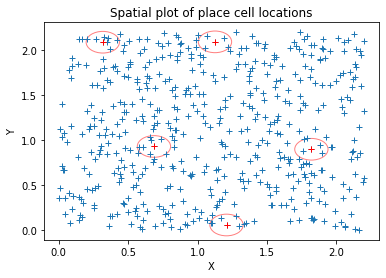

In [26]:
fig, ax = plt.subplots()
x,y = place_cell_ensembles[environment_idx].pcs.T

ax.plot(x, y, "+")
# add standard deviation circles to locations
for i in range(5):
    ax.plot(x[i], y[i], "r+")
    a_circle = plt.Circle((x[i], y[i]), params['pc_width'], fill=False, color=(1, 0, 0, 0.5))
    ax.add_artist(a_circle)

plt.title("Spatial plot of place cell locations")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Calculate grid scores using different implementations of the metric

In [ ]:
# Custom grid score
print("CUSTOM:", grid_score(ratemaps[1])) 

# CINPLA grid score
import spatial_maps as sm
print("CINPLA:", sm.gridness(ratemaps[1])) 

# BANINO (and Sorscher) grid scoring
from scores import GridScorer
"""
One difference from custom and CINPLA grid scores: 
1. Uses average difference between phase60 and phase30 correlations
"""
starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
coord_range=((0, environment.boxsize[0]), (0, environment.boxsize[1]))
box_width, box_height = 2.2, 2.2
coords_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
mask_parameters = zip(starts, ends.tolist())
scorer = GridScorer(nbins=res[0], coords_range=coords_range, mask_parameters=mask_parameters)

#score_60, score_90, max_60_mask, max_90_mask, sac, max_60_ind = zip(
#      *[scorer.get_scores(rm.reshape(res, res)) for rm in tqdm(rate_map_lores)])
score_60, score_90, max_60_mask, max_90_mask, sac = scorer.get_scores(ratemaps[1])
print("BANINO/SORSCHER:", score_60)

In [ ]:
# choose grid scoring function to use, e.g: grid_score, sm.gridness or scorer.get_scores
# for scorer.get_scores use: < (lambda rm: scorer.get_scores(rm)[0])(rate_map) >
grid_scoring_fn = lambda rate_map: sm.gridness(rate_map)

#map(grid_scoring_fn, *ratemaps)
grid_scoring_fn(ratemaps[1])

### Small analysis / checks / tests etc

In [ ]:
# Wr = model.recurrence.weight.detach().cpu().numpy()
Wr = model.RNN.weight_hh_l0.detach().cpu().numpy()
stats = lambda W : print(f"{np.min(W)=}, {np.max(W)=}, {np.min(abs(W))=}, {np.mean(W)=}, {np.std(W)=}, {np.sum(W**2)=}")
stats(Wr)
plt.imshow(Wr[:25,:25])
plt.colorbar()

In [ ]:
Wp = model.init_position_encoder.weight.detach().cpu().numpy()
stats = lambda W : print(f"{np.min(W)=}, {np.max(W)=}, {np.min(abs(W))=}, {np.mean(W)=}, {np.std(W)=}, {np.sum(W**2)=}")
stats(Wp)
plt.imshow(Wp)
plt.colorbar()